In [1]:
!pip install transformers
!pip install emoji
!pip install soynlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.8/416.8 kB 12.8 MB/s eta 0:00:00


In [2]:
import re
import os
import json
import emoji
import torch
import requests
import pandas as pd
from torch.optim import AdamW
from datasets import load_dataset
from transformers import get_scheduler
from soynlp.normalizer import repeat_normalize
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
apeach_df = pd.read_excel('/kaggle/input/apeach/apeach.xlsx')

print(len(apeach_df))
apeach_df.head(10)

11666


,text,class
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,1
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,0
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",1
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",0
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,1
5,10+8 진짜 이승기랑 비교된다,0
6,"100년안에 남녀간 성전쟁 한번 크게 치룬 후 일부다처제, 여성의 정치참여 금지, ...",1
7,10년뒤 윤서인은 분명히 재평가될것임. 말하나하나가 틀린게없음,0
8,10년만에 재미를 느끼는 프로였는데왜 니들때문에 폐지를해야되냐,1
9,10년차방탄팬인데 우리방탄처럼 성공은못하겠지만 일단 방탄의 부하가되고싶다는거니 이름...,1


In [4]:
def text_preprocess(text):
    pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣]+')
    url_pattern = re.compile(
        r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')
 
    text = pattern.sub(' ', text)
    text = emoji.replace_emoji(text, replace='') #emoji 삭제
    text = url_pattern.sub('', text)
    text = text.strip()
    text = repeat_normalize(text, num_repeats=2)
    
    return text

apeach_df['text'] = apeach_df['text'].apply(lambda x: text_preprocess(x))
apeach_df.head(10)

,text,class
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,1
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,0
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",1
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",0
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,1
5,10+8 진짜 이승기랑 비교된다,0
6,"100년안에 남녀간 성전쟁 한번 크게 치룬 후 일부다처제, 여성의 정치참여 금지, ...",1
7,10년뒤 윤서인은 분명히 재평가될것임. 말하나하나가 틀린게없음,0
8,10년만에 재미를 느끼는 프로였는데왜 니들때문에 폐지를해야되냐,1
9,10년차방탄팬인데 우리방탄처럼 성공은못하겠지만 일단 방탄의 부하가되고싶다는거니 이름...,1


In [8]:
model_name = "beomi/KcELECTRA-small-v2022"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, output_hidden_states=True)

# set device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-small-v2022 and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

In [32]:
batch_size =  32
learning_rate =  5e-5
num_epochs = 10
num_training_steps = 5000

In [23]:
# Custom Dataset 클래스
class MyDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        return text, label

my_dataset = MyDataset(apeach_df)
train_dataloader = DataLoader(my_dataset, shuffle=True, batch_size=batch_size)

In [34]:
optimizer = AdamW(model.parameters(), lr=learning_rate)

num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [35]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    print(epoch)
    for texts, labels in train_dataloader:
        # make inputs
        inputs = tokenizer(texts, padding=True, return_tensors='pt')
        inputs['labels'] = torch.tensor(labels)
        
        inputs = {k: v.to(device) for k,v in inputs.items()}
        
        
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/3650 [00:00<?, ?it/s]

0


/tmp/ipykernel_26/950733730.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs['labels'] = torch.tensor(labels)


1
2
3
4
5
6
7
8
9


In [37]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

model= model.to(device)
model.eval()

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

In [50]:
text = "파도처럼 부셔진 내맘"
encoded_input = tokenizer(text, return_tensors='pt').to(device)
output = model(**encoded_input)
print(output.hidden_states[-1].shape)
mean_embedding = torch.mean(output.hidden_states[-1], dim=1).squeeze()
mean_embedding.shape

torch.Size([1, 9, 256])


torch.Size([256])

In [64]:
# 임베딩을 저장할 리스트 초기화
embeddings = []

train_dataloader = DataLoader(my_dataset, shuffle=False, batch_size=batch_size)
# 데이터 로더를 통해 배치 단위로 처리
for texts, labgel in train_dataloader:
    inputs = tokenizer(texts, padding=True, return_tensors='pt')
    inputs = {k: v.to(device) for k,v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        cls_hidden_state = outputs.hidden_states[-1].cpu()
        mean_embedding = torch.mean(cls_hidden_state,dim=1).squeeze()
        embeddings.extend(mean_embedding)

In [67]:
my_df = pd.DataFrame({
  "sentence" : embeddings,
  "label": apeach_df['class']
})
my_df.head()

,sentence,label
0,"[tensor(0.1787), tensor(-0.1192), tensor(0.068...",1
1,"[tensor(-0.1335), tensor(0.1488), tensor(-0.11...",0
2,"[tensor(0.4312), tensor(0.0396), tensor(-0.049...",1
3,"[tensor(-0.2277), tensor(0.1403), tensor(-0.25...",0
4,"[tensor(0.1727), tensor(0.0603), tensor(0.2944...",1


In [86]:
import numpy as np
size = len(my_df)
matrix = np.zeros((size, 256))

for idx, vectors in enumerate(my_df['sentence']):
    vector = np.array(vectors)
    matrix[idx] =vector 

class_list = my_df['label']

In [88]:
import re
import emoji
import numpy as np 
import pandas as  pd
import seaborn as sns
import sys, re, argparse
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib import font_manager, rc

def visulize_sentences(title ,matrix, class_list, class_dict=None):
    
    vectors = matrix # 여기에 100차원 벡터 데이터를 입력하세요
    classes = class_list # 여기에 해당 벡터의 클래스 라벨(0에서 10 사이의 값)을 입력하세요
    
    if class_dict is not None:
        for idx, tmp_class in enumerate(classes):
            classes[idx] = class_dict[tmp_class]
        
    class_kind = len(set(classes))
    # t-SNE 임베딩 수행
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    vectors_tsne = tsne.fit_transform(vectors)

    # 시각화
    plt.figure(figsize=(20, 10))
    sns.scatterplot(
        x=vectors_tsne[:, 0], y=vectors_tsne[:, 1],
        hue=classes,
        palette=sns.color_palette("hsv", class_kind),
        legend="full",
        alpha=0.7
    )

    plt.title(title)
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 11666 samples in 0.003s...
[t-SNE] Computed neighbors for 11666 samples in 1.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11666
[t-SNE] Computed conditional probabilities for sample 2000 / 11666
[t-SNE] Computed conditional probabilities for sample 3000 / 11666
[t-SNE] Computed conditional probabilities for sample 4000 / 11666
[t-SNE] Computed conditional probabilities for sample 5000 / 11666
[t-SNE] Computed conditional probabilities for sample 6000 / 11666
[t-SNE] Computed conditional probabilities for sample 7000 / 11666
[t-SNE] Computed conditional probabilities for sample 8000 / 11666
[t-SNE] Computed conditional probabilities for sample 9000 / 11666
[t-SNE] Computed conditional probabilities for sample 10000 / 11666
[t-SNE] Computed conditional probabilities for sample 11000 / 11666
[t-SNE] Computed conditional probabilities for sample 11666 / 11666
[t-SNE] Mean sigma: 0.404422
[t-SNE] KL divergenc

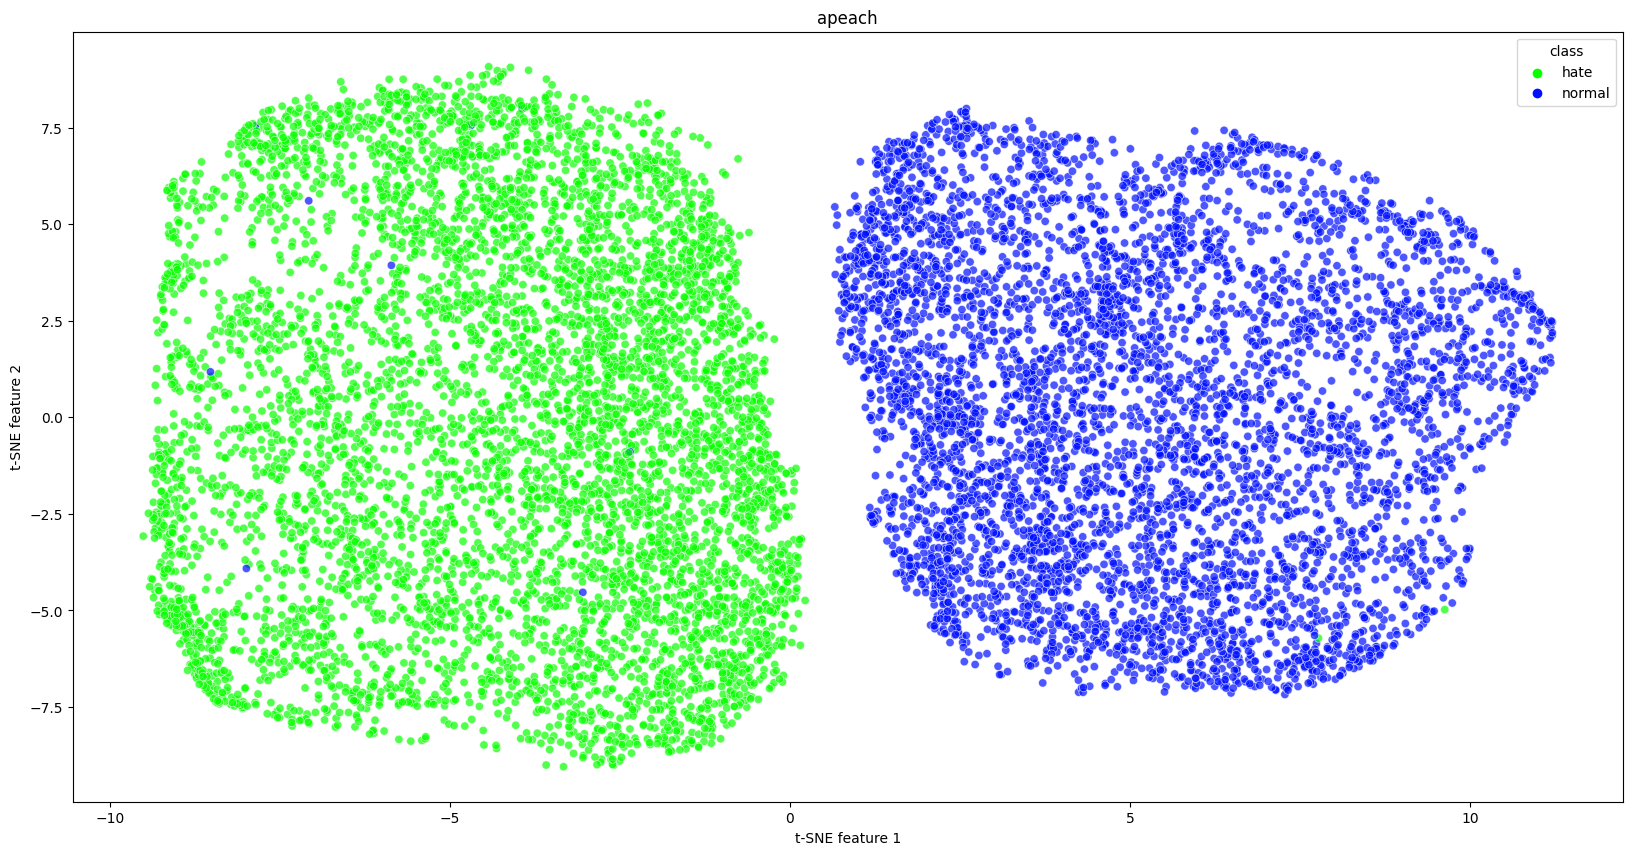

In [92]:
class_list = apeach_df['class']
visulize_sentences("apeach",matrix, class_list)